'''
 * Author:    Alexandre Choquette
 * Created:   Nov. 19, 2019
 * Patent:    PCT/CA2021/050468
'''

# Getting to know QOCA
In this tutorial, I will go over some code the QOCA variational form.
As an example, I apply QOCA to the Fermi-Hubbard model.

In [1]:
import os
import sys
# path to the repository directory
sys.path.insert(0, '/Users/alexandre/Documents/3-Doc/Projects/QOCA') # change

from imports import *

### First, let's build a QOCA instance
QOCA is built from the following Hamiltonian
$$H_{\text{QOCA}} = H_{\text{prob}} + H_{\text{drive}}$$
where both the problem Hamiltonian $H_{\text{prob}}$ and the drive Hamiltonian $H_{\text{drive}}$ are further separated into groups of terms.
\begin{align}
H_{\text{prob}} &= \sum_{i=1}^M H_i \\
H_{\text{drive}} &= \sum_{k=1}^S D_k.
\end{align}

The grouping behind the $H_i$'s is irrelevant to the QOCA construction, but is often chosen to be groups of commuting terms. The $D_k$'s are the drive operators and, by design, $[D_k,H_{\text{prob}}]\neq 0 \forall k$.

To specify a QOCA instance, we must provide two lists of Pauli strings: one corresponding to the terms of $H_{\text{prob}}$ and the other one to $H_{\text{drive}}$. Each list has the following construction:
```
pauli_operators = [[group_1],[group_2],[group_3],...]
```
where
```
[group_i] = [term_1, term_2, term_3,...]
```
and `term_i = 'XXII'` for example. The lenght of the strings should correspond to the number of qubits, so include identity operators.

Every `group_i` will be assigned a unique variational parameter. Note that the order terms appear in the list correspond to their order in the resulting quantum circuit. 

This way of instanciating the ansatz allows for great flexibility in choosing which Hamiltonian terms to include in the circuit and the way to parametrize them.

Let's see an example with the 2-site Hubbard model, which maps to 4 qubits. Note that the qubits are labeled as
$$|f_{0\uparrow}, f_{1\uparrow}; f_{0\downarrow}, f_{1\downarrow}\rangle$$
with $f_{i\sigma}\in \{0,1\}$ the occupancy of spin-orbital $i\sigma$.

In [3]:
num_qubits = 4
ham_ops    = [['XXII','YYII','IIXX','IIYY'], # hopping XX+YY terms for spins up and down (all with the same variational parameter)
              ['ZIZI','IZIZ']]               # on-site ZZ interaction
drive_ops  = [['ZXII','IIZX'],               # ad+a drive terms
              ['ZYII','IIZY']]               # -i(ad-a) drive terms

# Calling the QOCA ansatz
ansatz = QOCA(num_qubits, ham_ops, drive_ops, depth=1)

Verifying it has the correct number of parameters.

In [4]:
num_params = ansatz._num_parameters
print(num_params)

4


Constructing the circuit giving random paramters, just to check.

In [5]:
circ = ansatz.construct_circuit(np.random.rand(num_params))

Printing the circuit

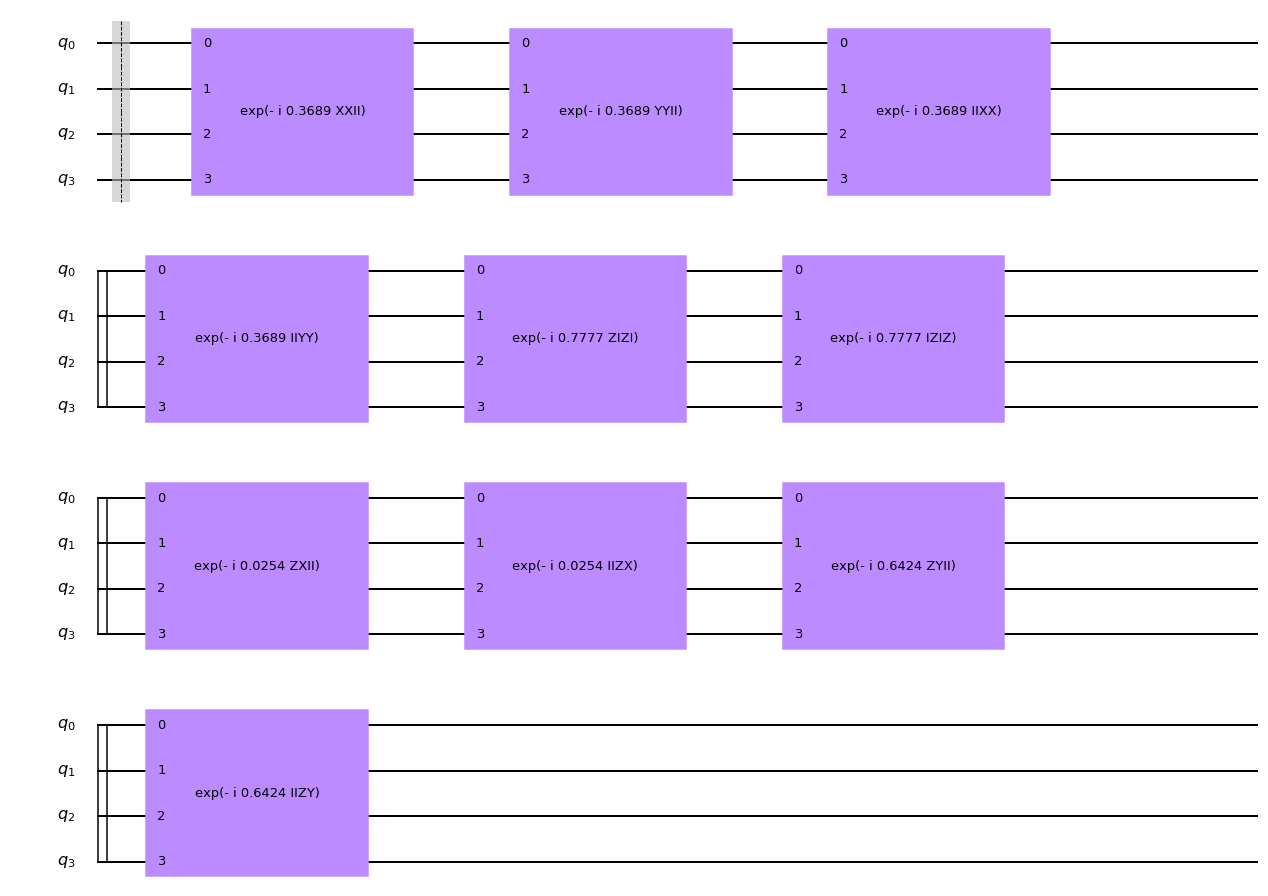

In [5]:
circ.draw(output='mpl')

Decomposing the circuit for the different terms

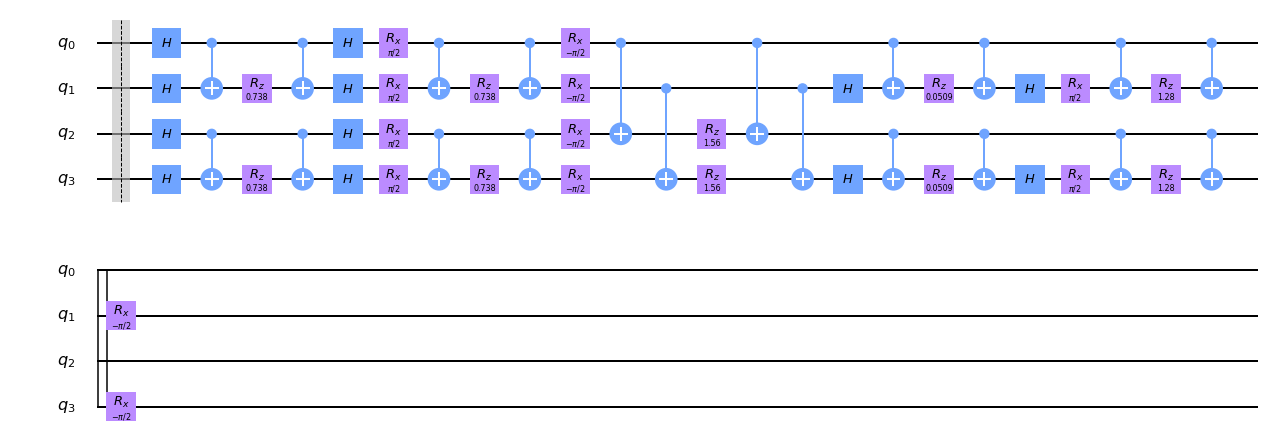

In [6]:
circ.decompose().draw(output='mpl')

## Applying QOCA to the 2-site Fermi-Hubbard model

We now turn to the Fermi-Hubbard model as an application of QOCA.
We first derive its Hamiltonian, first as a matrix, then as a list of Pauli strings and coefficients.

#### The model
The Fermi-Hubbard model is an iconic model in the study of strongly correlated materials.
It describes interacting spin-$\frac{1}{2}$ fermions on a lattice where each site can be occupied by up to two particles of opposite spins.
The Hamiltonian of the FHM for $L$ lattice sites takes the form
$$
H_{\text{FHM}} = t \sum_{\langle i,j \rangle, \sigma} a^\dagger_{i\sigma} a_{j\sigma} + U\sum_{i=1}^{L} n_{i\uparrow} n_{i\downarrow} - \mu \sum_{i,\sigma} n_{i\sigma}
$$
where $i,j$ are the lattice-site indices, and $\sigma=\{\uparrow,\downarrow\}$ labels the spin degree of freedom. 
In the first term, $\langle i,j \rangle$ denotes a sum over nearest-neighbor sites, and $n_{i\sigma} = a^\dagger_{i\sigma}a_{i\sigma}$ is the occupation operator of the spin-orbital labeled $i\sigma$. 

More details can be found in the QOCA paper at https://arxiv.org/abs/2008.01098.

### Matrix form

The function `Fermi_Hubbard_Hamiltonian` in the `hubbard.py` file generates the Hamiltonian matrix as a `QuTiP` Quantum object `Qobj`.

In [2]:
t           = -1.   # hopping amplitude
U           = 4.    # on-site energy
mu          = U/2.  # enforces half-filling
N           = 1     # number of rows of sites
M           = 2     # number of columns of sites
periodicity = False # apply periodic boundary conditions

FHM_matrix = Fermi_Hubbard_Hamiltonian(t, U, mu, N, M, periodic=periodicity)
FHM_matrix

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -2.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1. -4.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0. -4. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0. -2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.]
 [ 0.  0.  0.  0.  

### Pauli operator form

In order to measure the energy on a quantum computer, one must convert the Hamiltonian matrix into a qubit operator that is a sum of Pauli terms. Qiskit does it automatically when input a matrix, but this process is exponentially long when no prior information on the model is given, e.g. for 12 qubits it is too long to be ran on a laptop. For this reason, I coded a function that already generates the correct list of Pauli terms along with their coefficients.

The function `Fermi_Hubbard_Hamiltonian_Pauli` of `hubbard.py` returns the Fermi-Hubbard Hamiltonian as a `WeightedPauliOperator` object of Qiskit.

!!! IMPORTANT !!! 

As implemented, this function only works at half-filling, or when $\mu = U/2$.


In [3]:
t           = -1.   # hopping amplitude
U           = 4.    # on-site energy
mu          = U/2.  # enforces half-filling
N           = 1     # number of rows of sites
M           = 2     # number of columns of sites
periodicity = False # apply periodic boundary conditions

FHM_Pauli = Fermi_Hubbard_Hamiltonian_Pauli(t, U, mu, N, M, periodic=periodicity)

Printing the Pauli operators as a sanity check.

In [4]:
dict_to_print = FHM_Pauli.to_dict()
dict_to_print

{'paulis': [{'label': 'IIII', 'coeff': {'real': -2.0, 'imag': 0.0}},
  {'label': 'XXII', 'coeff': {'real': -0.5, 'imag': 0.0}},
  {'label': 'YYII', 'coeff': {'real': -0.5, 'imag': 0.0}},
  {'label': 'IIXX', 'coeff': {'real': -0.5, 'imag': 0.0}},
  {'label': 'IIYY', 'coeff': {'real': -0.5, 'imag': 0.0}},
  {'label': 'ZIZI', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'IZIZ', 'coeff': {'real': 1.0, 'imag': 0.0}}]}

Everything seems OK. All systems go!

#### More...
The files `hubbard.py` and `support_functions.py` contain many more functions that may be useful.

## Running a VQA experiment on the Hubbard model

To facilitate the numerics of running VQAs, I have created the `VQEproblem` class in the `VQEproblem.py` file.
To instanciate it, we need to specify a dictionary of all the necessary paramters such as the problem Hamiltonian, the ansatz, the optimizer, etc.
It also comprises useful functions to save the results data.
Using it is completely optional as most of what it does can also be done inline.

In [23]:
# create the InitialState object
num_qubits = 4
circuit = Hn_circuit(num_qubits, transpile_circuit=True)
initial_state = deepcopy(Custom(num_qubits, circuit=circuit)) # deepcopy to avoid some problems, might be useless now


global params
params = {
    # Hamiltonian params
    'Hamiltonian_params': {
        'H_generator':      hb.Fermi_Hubbard_Hamiltonian,       # function to generate the Hamiltonian matrix 
        'H_to_Pauli_op':    hb.Fermi_Hubbard_Hamiltonian_Pauli, # function to generate the Pauli op (if available)
        't':                -1.,
        'U':                4.,
        'mu':               2.,
        'N':                1,
        'M':                2,
        'periodic':         True
    },
    
    # VQE params
    'VQE_params': {
        # Variational form parameters
        'var_form_params': {
            'variational_form': QOCA,
            'variational_form_args': {
                    'hamiltonian_terms' : [['XXII','YYII','IIXX','IIYY'], ['ZIZI','IZIZ']],
                    'drive_terms'       : [['ZXII','IIZX'],['ZYII','IIZY']], 
                    'depth'             : 3,
                    'initial_state'     : initial_state
                }            
        },
        # Optimizer settings
        'optimizer_params': {
            'optimizer':             COBYLA,
            'optimizer_arguments':   {
                    'maxiter':100000, 
                    'disp':False, 
                    'rhobeg':np.pi/16, 
                    'tol':None
            },
            'cost_function':         None
        
        },
        # VQE_algorithm settings
        'vqe_algorithm_params': {
            'initial_point': 'zeros', # starts with all the params in 0. Set None for random.
            'write_to_file': False,
            'file_name':     'QOCA_depth_x',
            'file_dir':      os.getcwd()+'/results_QOCA/',
            'main_dir':      os.getcwd()+'/results_QOCA/'
        },
        
        # simulation settings, useful for parallelization
        'simulation_params': {
            'coupling_map':  None,
            'backend':       'statevector_simulator',
            'backend_options':  {
                'max_parallel_threads':             16, # see statevector_simulator.py for description
                'max_parallel_experiments':         0,  # of backend options
                #'max_memory_mb':                    0,
                'statevector_parallel_threshold':   1
            }
        },
        
        # Noise settings, not yet implemented
        'noise_params': {
            'turn_on_noise': False
        }
        
    }    
}

# create the VQEproblem instance
prob = VQEproblem(**params)

### Print the circuit to verify that we have the right ansatz

In [24]:
circuit = prob.circuit_generator()
transpiled_circ = transpile(circuit.decompose().decompose().decompose())
print('Circuit depth: ', transpiled_circ.depth())
print('Gates: ', transpiled_circ.count_ops())
print('Number of parameters: ',prob._var_form._num_parameters)
circuit.decompose().draw()

Circuit depth:  64
Gates:  OrderedDict([('cx', 60), ('u2', 40), ('u1', 30), ('u3', 18), ('barrier', 3)])
Number of parameters:  12


### Solve the model classically to compare the results

In [25]:
############## Classical solver ##############

# Get the Hamiltonian. qt2qk converts from the the qutip to qiskit labelling of qubits
H = qt2qk(params['Hamiltonian_params']['H_generator'](**params['Hamiltonian_params']))
evals, ekets = H.eigenstates()

eval_count = 250, energy = -4.80393833185555
eval_count = 500, energy = -4.826220612396458
eval_count = 750, energy = -4.8281920184140334
eval_count = 1000, energy = -4.828386817072182
eval_count = 1250, energy = -4.828417436671663
The computed ground state energy is: -4.828420210347
The exact ground state energy is: -4.82842712474619
The fidelity with the exact ground state is: 0.9999972429450078
.
.
.
Time of the simulation: 53.43542009600003
The number of steps is: 1311
Energy plot:


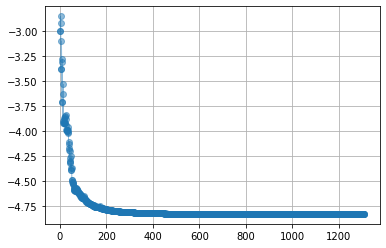

Parameter plot:


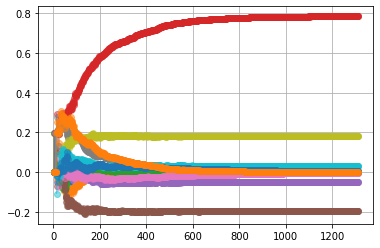

In [26]:
############## Run the VQE simulation ##############

# Run the simulation
# print('Starting depth: ', depth)
start_time = timeit.default_timer()
results = prob.run_sim()
end_time = timeit.default_timer()

# Compute final state fidelity with the exact GS
gs_ket = ekets[0]
final_ket = Qobj(prob.results_transcript['final_results']['min_vector'], 
                                                    dims = gs_ket.dims)
fidelity = abs(final_ket.overlap(gs_ket))**2

# Print results
print('The exact ground state energy is: {}'.format(np.real(evals[0])))
print('The fidelity with the exact ground state is: {}'.format(fidelity))
print('.\n.\n.')
print('Time of the simulation: {}'.format(end_time-start_time))
print('The number of steps is: {}'.format(results['num_optimizer_evals']))
print('Energy plot:')
sf.plot(prob.results_transcript['eval_count'],[prob.results_transcript['mean_energy']])
print('Parameter plot:')
sf.plot(prob.results_transcript['eval_count'],[prob.results_transcript['parameter_sets']])